<a href="https://colab.research.google.com/github/Ayush310803/ViT/blob/main/Deeplabv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
!pip install torch torchvision matplotlib numpy opencv-python

In [22]:
import torch
import torchvision
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

In [23]:
model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True)
model.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [24]:
image_path = "/content/download.jpeg"
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [25]:
def preprocess_image(img):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((520, 520)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform(img).unsqueeze(0)

input_tensor = preprocess_image(image_rgb)


In [26]:
def segment_image(model, input_tensor):
    with torch.no_grad():
        output = model(input_tensor)["out"]
    output_mask = torch.argmax(output.squeeze(), dim=0).cpu().numpy()
    return output_mask

segmentation_mask = segment_image(model, input_tensor)

In [28]:
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")
segmentation_mask_uint8 = segmentation_mask.astype(np.uint8)
r = Image.fromarray(segmentation_mask_uint8).resize(Image.fromarray(image_rgb).size)
r.putpalette(colors)

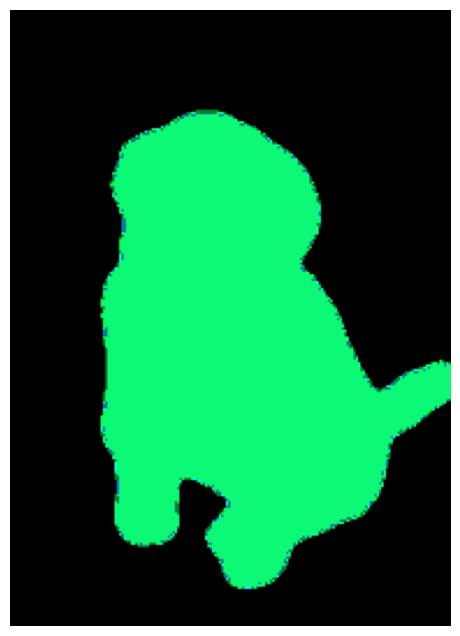

In [29]:
plt.figure(figsize=(8, 8))
plt.imshow(r)
plt.axis("off")
plt.show()

In [31]:
!pip install tensorflow
!pip install keras

In [32]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt

In [33]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding=padding,
        use_bias=use_bias,
        kernel_initializer=tf.keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def ASPP(inputs):
    shape = inputs.shape

    y1 = layers.AveragePooling2D(pool_size=(shape[1], shape[2]))(inputs)
    y1 = convolution_block(y1, kernel_size=1, use_bias=True)
    y1 = layers.UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y1)

    y2 = convolution_block(inputs, kernel_size=1, dilation_rate=1)
    y3 = convolution_block(inputs, dilation_rate=6)
    y4 = convolution_block(inputs, dilation_rate=12)
    y5 = convolution_block(inputs, dilation_rate=18)

    y = layers.Concatenate()([y1, y2, y3, y4, y5])
    y = convolution_block(y, kernel_size=1)
    return y


def DeeplabV3Plus(image_size, num_classes):
    inputs = layers.Input(shape=(image_size, image_size, 3))

    resnet50 = tf.keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=inputs
    )
    x = resnet50.get_layer("conv4_block6_out").output
    y = resnet50.get_layer("conv5_block3_out").output
    y = ASPP(y)
    y = layers.UpSampling2D((4, 4), interpolation="bilinear")(y)
    x = convolution_block(x, num_filters=48, kernel_size=1)
    x = layers.Concatenate()([x, y])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D((4, 4), interpolation="bilinear")(x)

    outputs = layers.Conv2D(num_classes, kernel_size=(1, 1), activation="softmax")(x)
    return Model(inputs, outputs)

In [43]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
!tar -xf VOCtrainval_11-May-2012.tar -C data

--2025-02-21 11:39:15--  http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1999639040 (1.9G) [application/x-tar]
Saving to: ‘VOCtrainval_11-May-2012.tar’

VOCtrainval_11-May- 100%[===================>]   1.86G  30.5MB/s    in 96s     

2025-02-21 11:40:52 (19.8 MB/s) - ‘VOCtrainval_11-May-2012.tar’ saved [1999639040/1999639040]

tar: data: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [46]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

def preprocess_image(image, label, image_size=512):
    image = tf.image.resize(tf.convert_to_tensor(image), (image_size, image_size))
    image = tf.keras.applications.resnet50.preprocess_input(image)
    label = tf.image.resize(tf.convert_to_tensor(label), (image_size, image_size), method="nearest")

    return image, label

import tensorflow_datasets as tfds

dataset, info = tfds.load("voc/2012", split="train", as_supervised=True, with_info=True)

train_dataset = dataset.map(preprocess_image).batch(8).prefetch(tf.data.AUTOTUNE)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

ChunkedEncodingError: ('Connection broken: IncompleteRead(524435649 bytes read, 1326190911 more expected)', IncompleteRead(524435649 bytes read, 1326190911 more expected))